# Structural Variant Discovery, Genotyping and Analyses
## Variant Discovery with SMOOVE
Structural variant (SV) analyses followed a similar pipeline where variant discovery, variant quality filtering, and initial genotyping was performed under recommended pipelines. High quality genotypes representing homozygous reference, heterozygous and homozygous alternate calls were then plotted with SAMplot and evaluated using PlotCritic for call refinement. Calls passing evaluation with PlotCritic were then merged using SURVIVOR and used to construct a genome graph with the VG tools suite. Detailed methods for each of these steps using Delly, and Smoove are outlined below.  

Merging calls

## Filtering Initial Calls
### Manta
For filtering raw Manta calls, all reads had to pass all 'hard' filtering thresholds and have 'PRECISE' breakpoints.  

In [ ]:
bcftools view -i 'FILTER=="PASS" & IMPRECISE==0' \
    -O z -o manta/03_fairy_filtered.vcf.gz manta/02_fairy_SVcalls_INVconverted.vcf
bcftools index manta/03_fairy_filtered.vcf.gz

bcftools view -i 'FILTER=="PASS" & IMPRECISE==0' \
    -O z -o manta/03_kaki_filtered.vcf.gz manta/02_kaki_SVcalls_INVconverted.vcf
bcftools index manta/03_kaki_filtered.vcf.gz

## Genotyping
### Manta
We used graphtyper2 to genotype Manta SV calls as per:

In [ ]:
while read -r line
    do
    printf "STARTED GENOTYPING $line AT "
    date
    graphtyper genotype_sv reference/SP01_5kb_ragtag.fa manta/03_fairy_filtered.vcf.gz --sams=fairy.list --threads=16 --region=$line
done < fairy_chroms.tsv

This genotyping and filtering approach was repeated for both kakī datasets.  

|   SV Type   | Raw FT Genotypes | Filtered FT Genotypes | KĪ 50x Genotypes | KĪ 50x GenoFiltered | KĪ 10x Genotypes | KĪ 10x GenoFiltered |
|:-----------:|:----------------:|:---------------------:|:----------------:|:-------------------:|:----------------:|:-------------------:|
|  Deletion   |       5,948      |         1,087         |       6,912      |         533         |      6,299       |         308         |
| Duplication |        450       |           41          |         674      |          15         |       561        |           7         |
|  Insertion  |       3,659      |         1,544         |       5,304      |        1,192        |      4,431       |         724         |
|  Inversion  |        486       |           0           |         61       |          0          |        49        |          0          |
|    Total    |      10,543      |         2,672         |      12,951      |        1,740        |     11,340       |        1,039        |

### SMOOVE
Genotyping

Once all samples were individually genotyped for sites called for their populations, and the two fairy tern populations genotyped for GLOBAL sites, all genotypes were then merged into their respective population data sets.  

## Genotype Filtering
### SMOOVE
Genotypes for individual chromosomes were then merged and filtered to include SVs that passed in the `AGGREGATED` genotyping model for graphtyper and had a mean GQ>=25.

## SV Evaluation
### Manta
Genotypes were visually inspected for support by plotting with SAMplot and scoring with [PlotCritic](https://github.com/jbelyeu/PlotCritic). As with Smeds et al. only one curator was used to prevent the overfiltering of genotypes. We used BCFtools to first extract regions of interest for each individual.

These regions were then plotted into individual folders with SAMPLOT for each dataset.  

We then created PlotCritic projects and manually scored all SV genotypes.  

Scored genotypes were then extracted from the PlotCritic Summary files upon completion of scoring

The number counts of each genotype for each individual were then acquired as below.

## Structural Variant Characteristics
### Insights from high coverage data for kakī
To explore the effect of read depth on SV discovery, we leverage the kakī data by performing SV discovery with Manta using all aligned reads for each individual, and again after randomly subsampling the alignment files to mirror alignment depths observed in the tara iti data set (e.g., ~5x - 13x coverage). Below we plot comparisons between all SVs discovered, and those that passes initial filtering thresholds in both of these data sets.  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu
from scipy import stats

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


### Count Comparisons
Next we examine the number of SVs by type found within the fairy tern species complex and each of the kakī data sets examined here. We first counted the total Number of SVs found in Manta, those passing SV quality threshold and used as input for genotyping and finally those that passed genotyping filters. 

In [2]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
glSVs = SVs[SVs['Population']=='GLOBAL']
kiSVs = SVs[SVs['Population']=='KI']

SVs.head()

,Chromosome,Position,SV Type,Length,Dataset,Population
0,CM020437.1_RagTag,117049698,BND,.,Smoove Unfiltered,AU
1,CM020438.1_RagTag,32387641,BND,.,Smoove Unfiltered,AU
2,CM020437.1_RagTag,124552108,BND,.,Smoove Unfiltered,AU
3,CM020438.1_RagTag,167204298,BND,.,Smoove Unfiltered,AU
4,CM020437.1_RagTag,153678011,BND,.,Smoove Unfiltered,AU


In [3]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


/tmp/ipykernel_95333/752071257.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
/tmp/ipykernel_95333/752071257.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3,0].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
/tmp/ipykernel_95333/752071257.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)


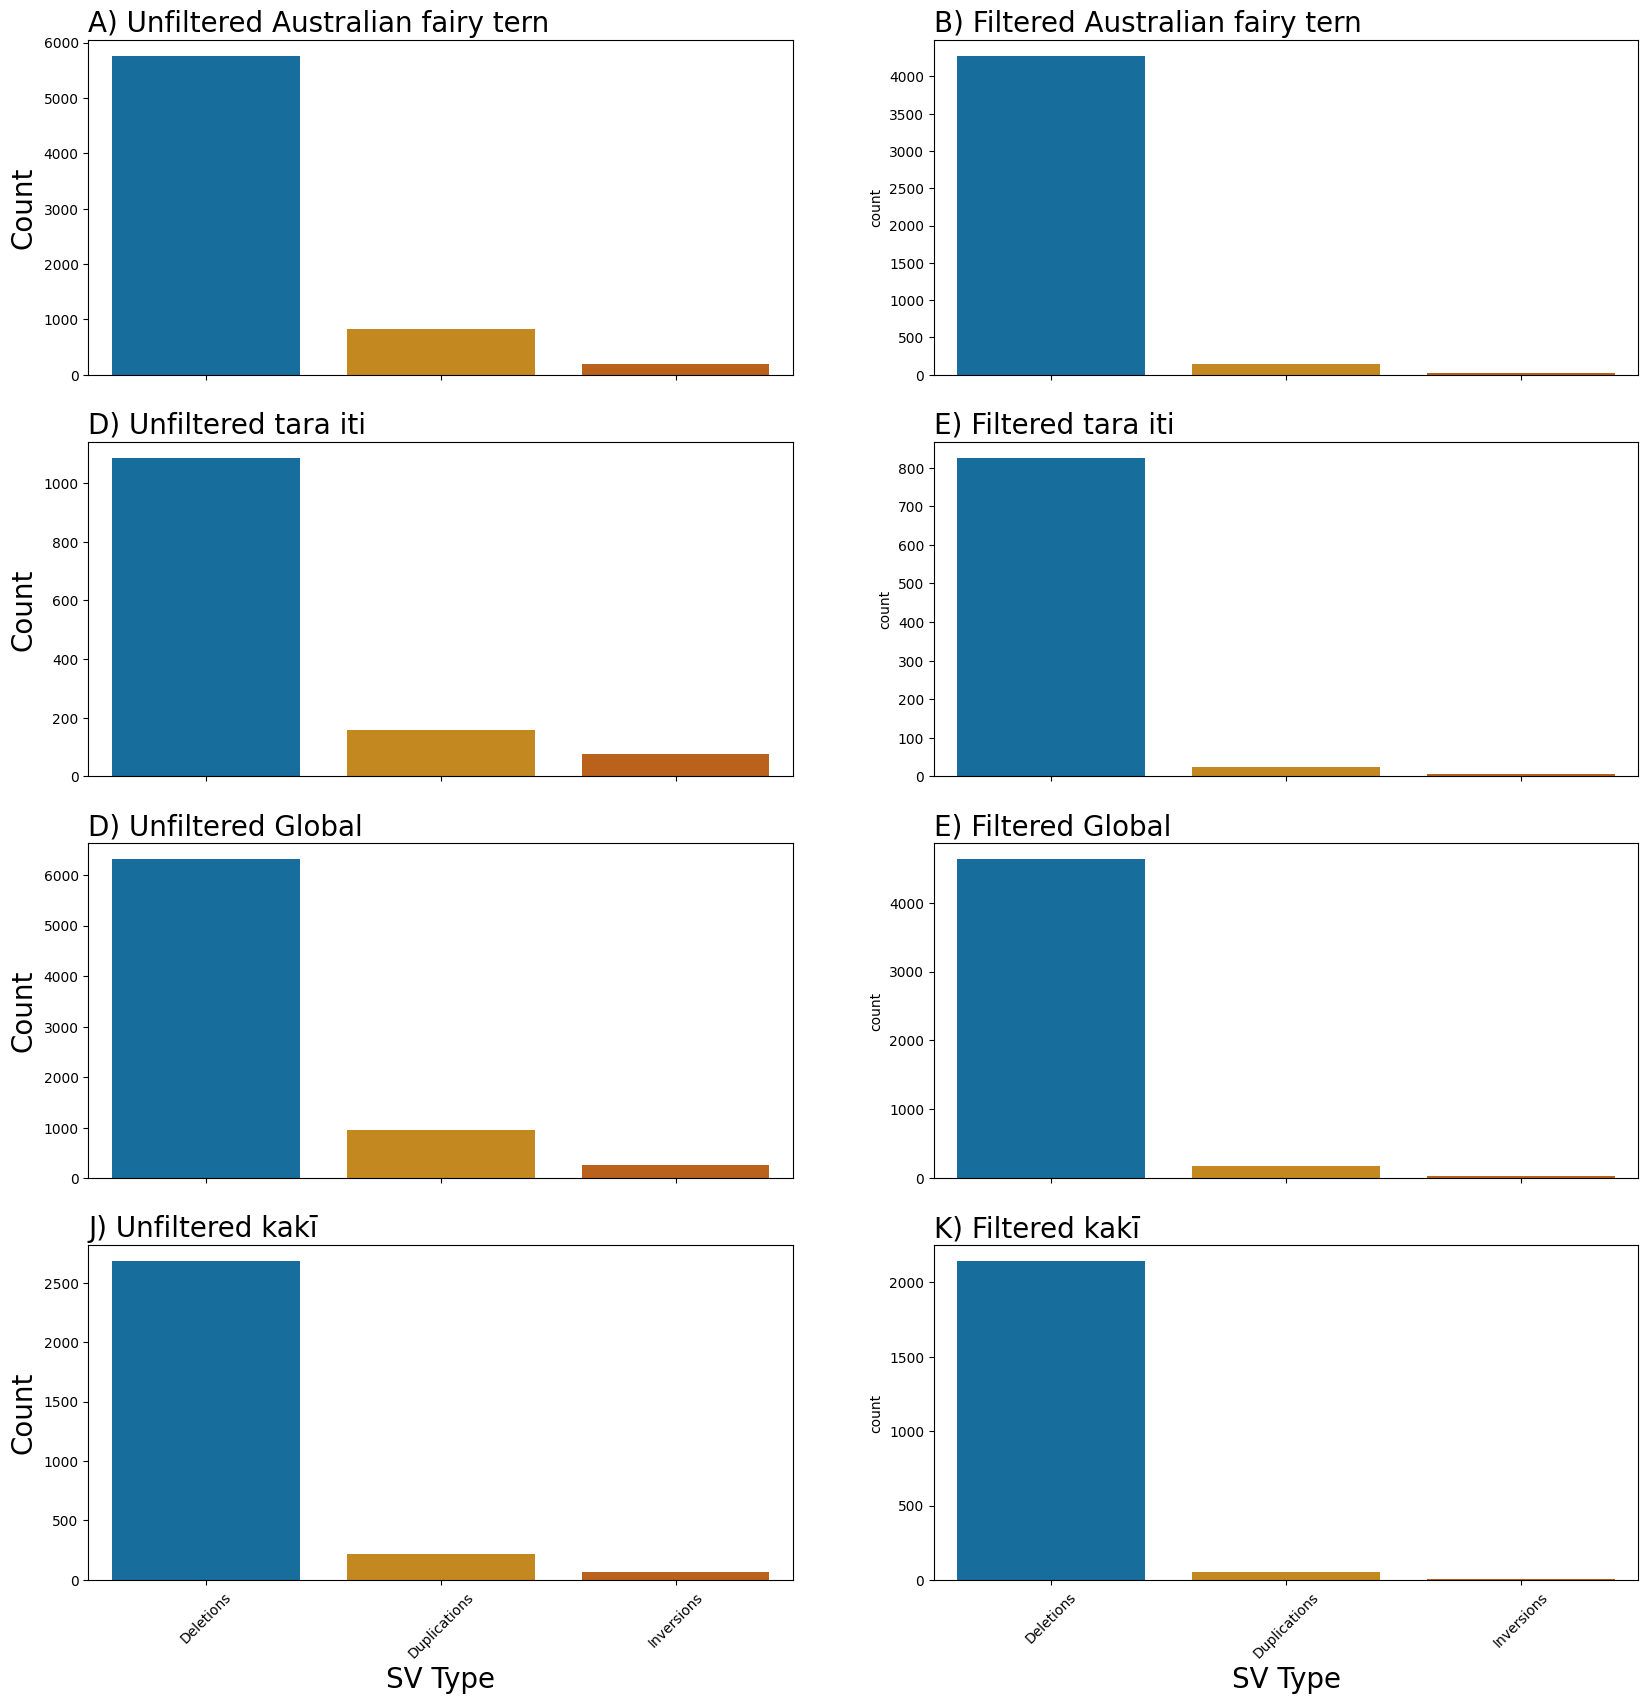

In [25]:
palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INV': '#d55e00'
}
order = ['DEL', 'DUP', 'INV']

fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=False)

sns.countplot(auSVs[auSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[0,0])
axes[0,0].set_title('A) Unfiltered Australian fairy tern', fontsize=20, loc='left')
axes[0,0].set_ylabel('Count', fontsize=20)
#axes[0,0].set_ylim(0, 14000)
sns.countplot(auSVs[auSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[0,1])
axes[0,1].set_title('B) Filtered Australian fairy tern', fontsize=20, loc='left')
axes[0,1].set_xlabel('SV Type', fontsize=20)
axes[0,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[0,1].set_ylim(0, 1700)

sns.countplot(tiSVs[tiSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[1,0])
axes[1,0].set_title('D) Unfiltered tara iti', fontsize=20, loc='left')
axes[1,0].set_ylabel('Count', fontsize=20)
#axes[1,0].set_ylim(0, 14000)
sns.countplot(tiSVs[tiSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[1,1])
axes[1,1].set_title('E) Filtered tara iti', fontsize=20, loc='left')
#axes[1,1].set_ylim(0, 1700)

sns.countplot(glSVs[glSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[2,0])
axes[2,0].set_title('D) Unfiltered Global', fontsize=20, loc='left')
axes[2,0].set_ylabel('Count', fontsize=20)
#axes[2,0].set_ylim(0, 14000)
sns.countplot(glSVs[glSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[2,1])
axes[2,1].set_title('E) Filtered Global', fontsize=20, loc='left')
#axes[2,1].set_ylim(0, 1700)

sns.countplot(kiSVs[kiSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[3,0])
axes[3,0].set_title('J) Unfiltered kakī', fontsize=20, loc='left')
axes[3,0].set_ylabel('Count', fontsize=20)
axes[3,0].set_xlabel('SV Type', fontsize=20)
axes[3,0].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[3,0].set_ylim(0, 14000)
sns.countplot(kiSVs[kiSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[3,1])
axes[3,1].set_title('K) Filtered kakī', fontsize=20, loc='left')
axes[3,1].set_xlabel('SV Type', fontsize=20)
axes[3,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[3,1].set_ylim(0, 1700)

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/SV_counts.png', dpi=300, bbox_inches='tight')

Counts per chromosome

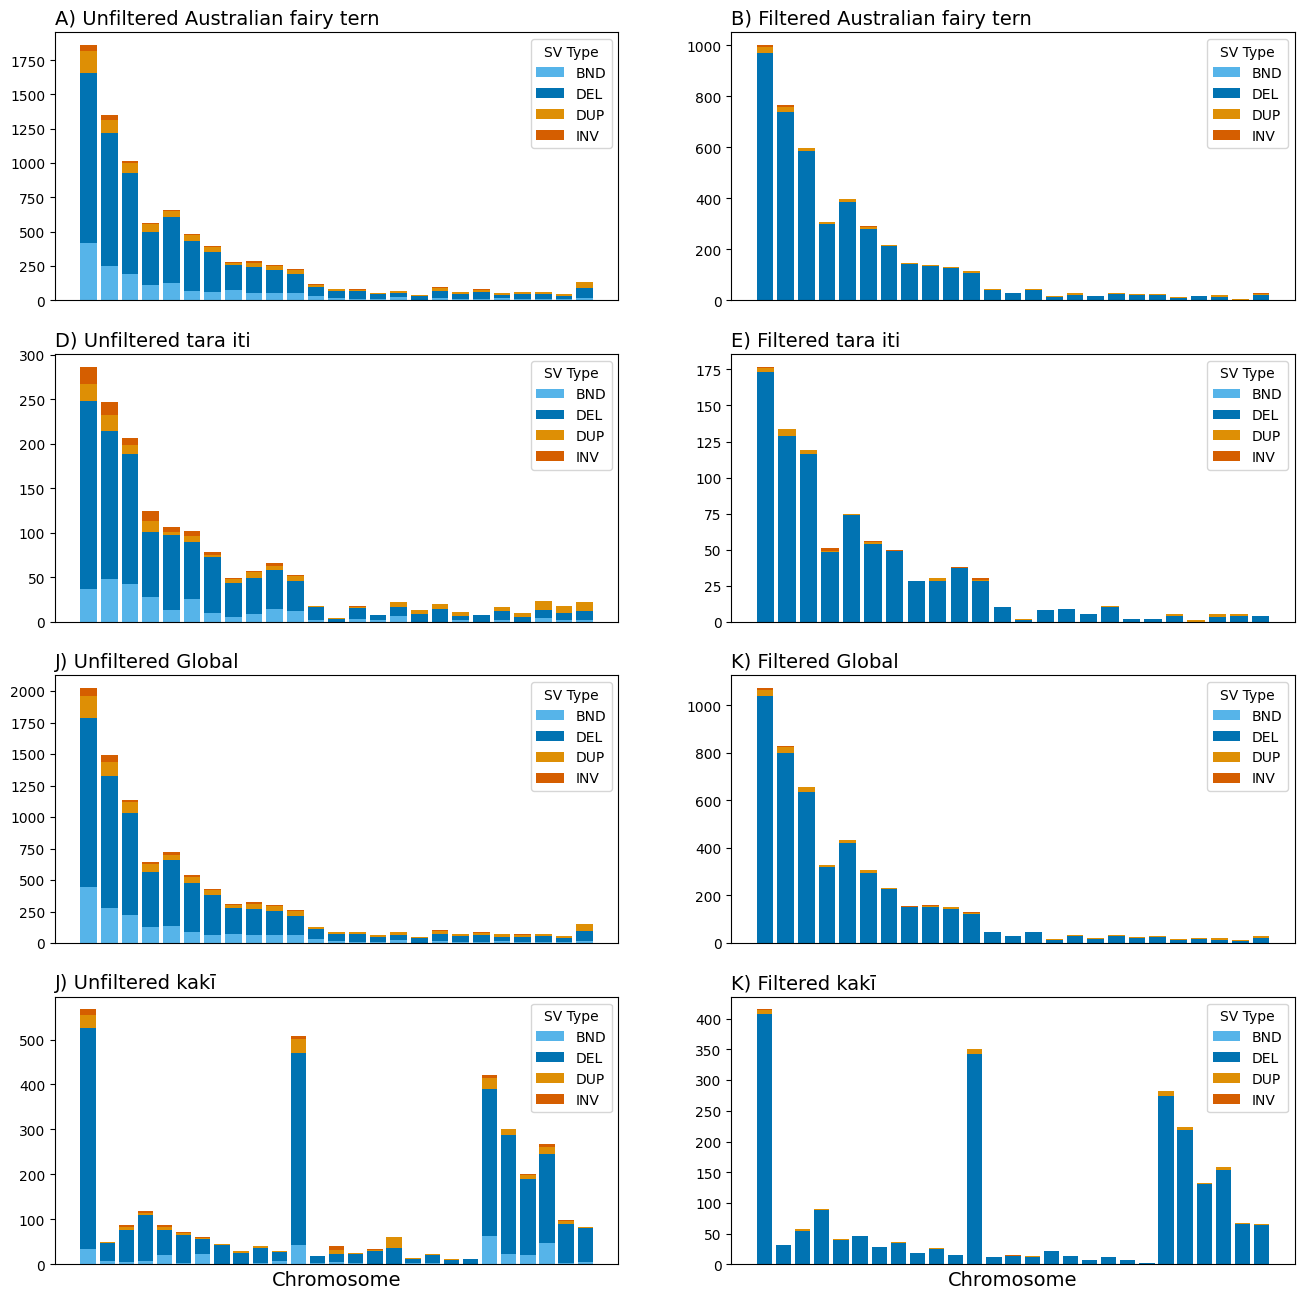

In [26]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
glSVs = SVs[SVs['Population']=='GLOBAL']
kiSVs = SVs[SVs['Population']=='KI']

palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INS': '#029e73',
    'INV': '#d55e00'
}
order = ['BND', 'DEL', 'DUP', 'INV']

def plot_stacked_bar(data, dataset, ax, title):
    crosstab = pd.crosstab(data[data['Dataset'] == dataset]['Chromosome'], data[data['Dataset'] == dataset]['SV Type']).reindex(columns=order, fill_value=0)
    bottom = np.zeros(len(crosstab))
    for sv_type in order:
        ax.bar(crosstab.index, crosstab[sv_type], bottom=bottom, label=sv_type, color=palette[sv_type])
        bottom += crosstab[sv_type]
    ax.set_title(title, fontsize=14, loc='left')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.legend(title='SV Type')

fig, axes = plt.subplots(4, 2, figsize=(16, 16), sharex=False, sharey=False)

plot_stacked_bar(auSVs, 'Smoove Unfiltered', axes[0,0], 'A) Unfiltered Australian fairy tern')
plot_stacked_bar(auSVs, 'Smoove filtered', axes[0,1], 'B) Filtered Australian fairy tern')
#plot_stacked_bar(auSVs, 'Genotyped', axes[0,2], 'C) Genotyped Australian fairy tern')
plot_stacked_bar(tiSVs, 'Smoove Unfiltered', axes[1,0], 'D) Unfiltered tara iti')
plot_stacked_bar(tiSVs, 'Smoove filtered', axes[1,1], 'E) Filtered tara iti')
#plot_stacked_bar(tiSVs, 'Genotyped', axes[1,2], 'F) Genotyped tara iti')
plot_stacked_bar(glSVs, 'Smoove Unfiltered', axes[2,0], 'J) Unfiltered Global')
plot_stacked_bar(glSVs, 'Smoove filtered', axes[2,1], 'K) Filtered Global')
#plot_stacked_bar(glSVs, 'Genotyped', axes[2,2], 'L) Filtered kakī')
plot_stacked_bar(kiSVs, 'Smoove Unfiltered', axes[3,0], 'J) Unfiltered kakī')
plot_stacked_bar(kiSVs, 'Smoove filtered', axes[3,1], 'K) Filtered kakī')
#plot_stacked_bar(kiSVs, 'Genotyped', axes[3,2], 'L) Filtered kakī')

axes[3,0].set_xlabel('Chromosome', fontsize=14)
axes[3,1].set_xlabel('Chromosome', fontsize=14)

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/SV_chr_counts.png', dpi=300, bbox_inches='tight')

As this plot demonstrates, the vast majority of Deletions were called on chromosome 1 in fairy terns and kakī. For fairy terns, deletions were only called on three other chromosomes (corresponding to chromosome 2, 3, and 12), while there were deletions called on nine other chromosomes in kakī (corresponding to chromosomes 2, 3, 6, 9, 11, 12, 13, 24, and 27). In contrast, insertions were more consistently distributed among individuals chromosomes and the number of insertions generally corresponded to chromosome size. The distribution of duplications is more challenging to infer as they are very infrequent in either data set, but were only genotyped on two individuals chromosomes in either case. 

### Proportion of chromosome impacted
As above, we plot the number of SVs per chromosome while accounting for aggregate number of base-pairs impacted relative to chromosome size.  

In [41]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[(SVs['SV Type']!='.') & (SVs['Length']!='.')]
SVs['Length'] = SVs['Length'].astype(int)

ti_chromLength = pd.read_csv('new_TI/hifiasm_longstitch_racon_ragtag/autosomes.bed', delimiter = '\t', names=['Chromosome', 'Start', 'Total Chr Length'])
ki_chromLength = pd.read_csv('kaki_genome/kaki_autosomes.bed', delimiter = '\t', names=['Chromosome', 'Start', 'Total Chr Length'])

SV_prop = SVs.groupby(['Chromosome', 'SV Type', 'Population', 'Dataset'])['Length'].sum().reset_index(name='Total SV Length')

auSV_prop = SV_prop[SV_prop['Population']=='AU']
tiSV_prop = SV_prop[SV_prop['Population']=='TI']
glSV_prop = SV_prop[SV_prop['Population']=='GLOBAL']
kiSV_prop = SV_prop[SV_prop['Population']=='KI']

auSV_prop.head()

,Chromosome,SV Type,Population,Dataset,Total SV Length
0,CM020437.1_RagTag,DEL,AU,Smoove Unfiltered,600734667
1,CM020437.1_RagTag,DEL,AU,Smoove filtered,1804223
6,CM020437.1_RagTag,DUP,AU,Smoove Unfiltered,412567331
7,CM020437.1_RagTag,DUP,AU,Smoove filtered,132197
12,CM020437.1_RagTag,INV,AU,Smoove Unfiltered,17549708


In [42]:
auSV_prop = pd.merge(auSV_prop, ti_chromLength, on=['Chromosome'])
tiSV_prop = pd.merge(tiSV_prop, ti_chromLength, on=['Chromosome'])
glSV_prop = pd.merge(glSV_prop, ti_chromLength, on=['Chromosome'])
kiSV_prop = pd.merge(kiSV_prop, ki_chromLength, on=['Chromosome'])

tiSV_prop.head()

,Chromosome,SV Type,Population,Dataset,Total SV Length,Start,Total Chr Length
0,CM020437.1_RagTag,DEL,TI,Smoove Unfiltered,3172103,0,232304906
1,CM020437.1_RagTag,DEL,TI,Smoove filtered,340863,0,232304906
2,CM020437.1_RagTag,DUP,TI,Smoove Unfiltered,3811606,0,232304906
3,CM020437.1_RagTag,DUP,TI,Smoove filtered,17415,0,232304906
4,CM020437.1_RagTag,INV,TI,Smoove Unfiltered,1293108,0,232304906


In [43]:
auSV_prop.head()

,Chromosome,SV Type,Population,Dataset,Total SV Length,Start,Total Chr Length
0,CM020437.1_RagTag,DEL,AU,Smoove Unfiltered,600734667,0,232304906
1,CM020437.1_RagTag,DEL,AU,Smoove filtered,1804223,0,232304906
2,CM020437.1_RagTag,DUP,AU,Smoove Unfiltered,412567331,0,232304906
3,CM020437.1_RagTag,DUP,AU,Smoove filtered,132197,0,232304906
4,CM020437.1_RagTag,INV,AU,Smoove Unfiltered,17549708,0,232304906


In [45]:
auSV_prop['Chr Proportion'] = auSV_prop['Total SV Length'] / auSV_prop['Total Chr Length']
tiSV_prop['Chr Proportion'] = tiSV_prop['Total SV Length'] / tiSV_prop['Total Chr Length']
glSV_prop['Chr Proportion'] = glSV_prop['Total SV Length'] / glSV_prop['Total Chr Length']
kiSV_prop['Chr Proportion'] = kiSV_prop['Total SV Length'] / kiSV_prop['Total Chr Length']

auSV_prop[auSV_prop['Dataset']=='Smoove filtered'].head()

,Chromosome,SV Type,Population,Dataset,Total SV Length,Start,Total Chr Length,Chr Proportion
1,CM020437.1_RagTag,DEL,AU,Smoove filtered,1804223,0,232304906,0.007767
3,CM020437.1_RagTag,DUP,AU,Smoove filtered,132197,0,232304906,0.000569
5,CM020437.1_RagTag,INV,AU,Smoove filtered,88700,0,232304906,0.000382
7,CM020438.1_RagTag,DEL,AU,Smoove filtered,935595,0,183653636,0.005094
9,CM020438.1_RagTag,DUP,AU,Smoove filtered,679892,0,183653636,0.003702


In [39]:
auSV_prop.head()

,Chromosome,SV Type,Population,Dataset,Total SV Length,Start,Total Chr Length
0,CM020437.1_RagTag,DEL,AU,Smoove Unfiltered,600734667,0,232304906
1,CM020437.1_RagTag,DEL,AU,Smoove filtered,1804223,0,232304906
2,CM020437.1_RagTag,DUP,AU,Smoove Unfiltered,412567331,0,232304906
3,CM020437.1_RagTag,DUP,AU,Smoove filtered,132197,0,232304906
4,CM020437.1_RagTag,INV,AU,Smoove Unfiltered,17549708,0,232304906


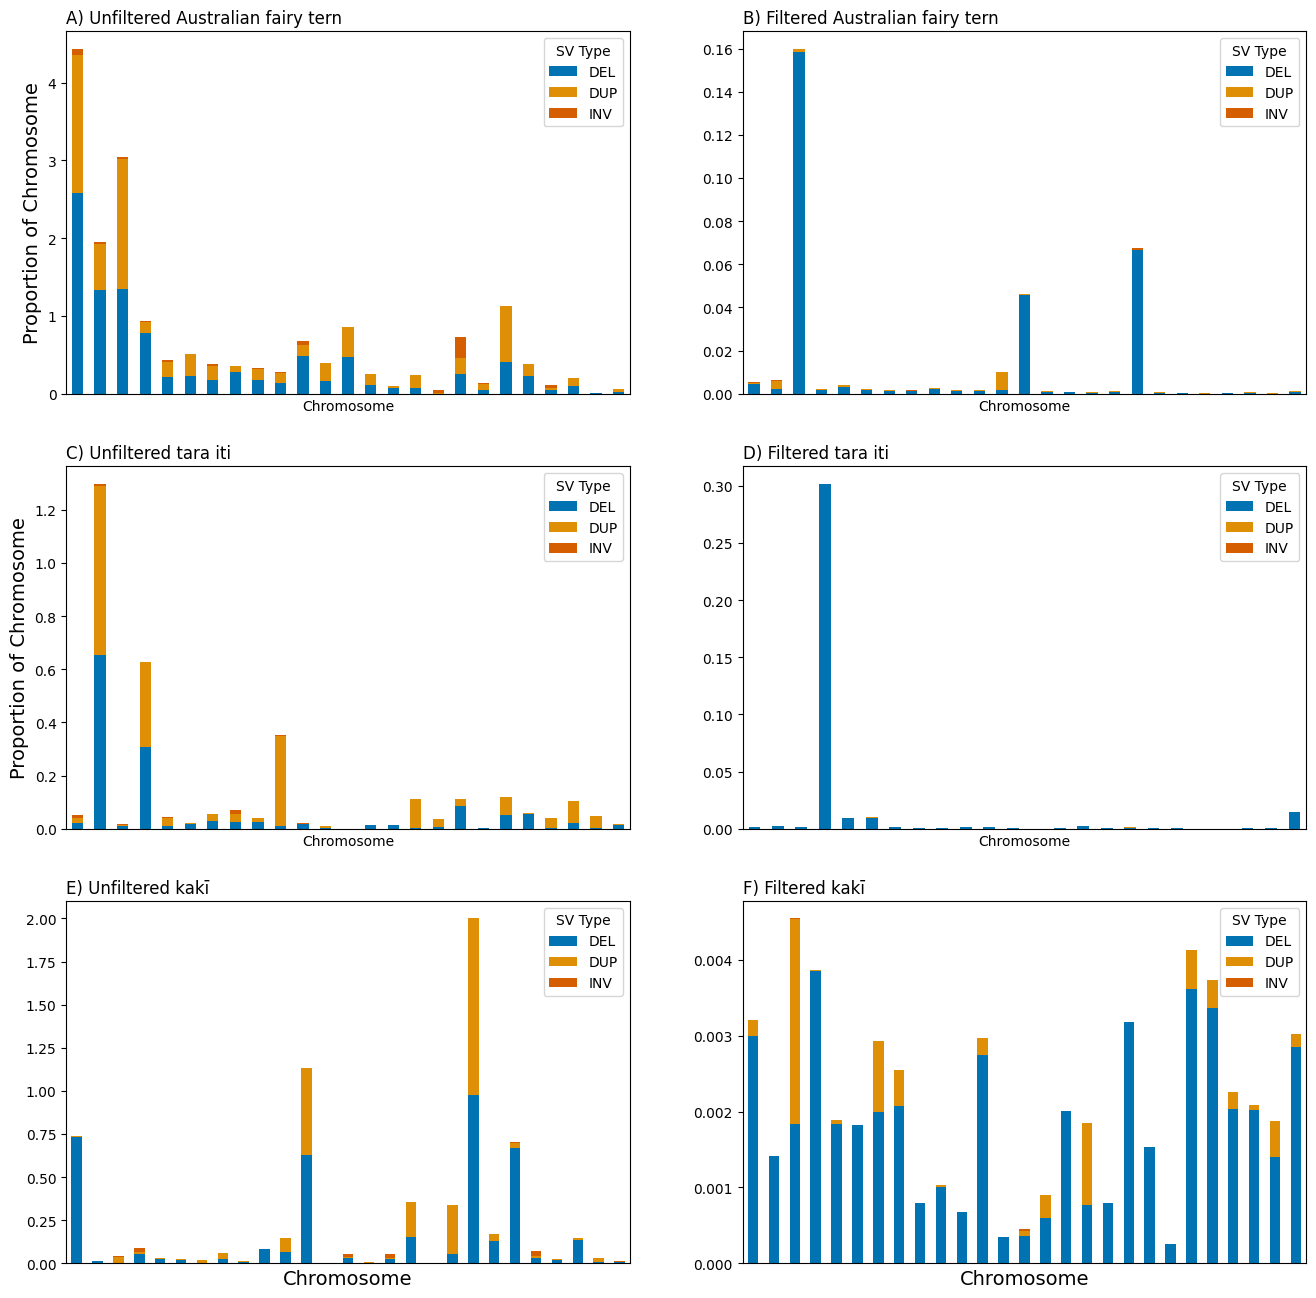

In [ ]:
palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INV': '#029e73'
}
order = ['BND', 'DEL', 'DUP', 'INV']

def plot_stacked_bar(df, dataset_filter, ax, title):
    df_filtered = df[df['Dataset'] == dataset_filter]
    pivot_df = df_filtered.pivot(index='Chromosome', columns='SV Type', values='Chr Proportion')
    pivot_df = pivot_df.fillna(0)
    
    pivot_df.plot(kind='bar', stacked=True, color=[palette.get(x) for x in pivot_df.columns], ax=ax)
    
    ax.set_title(title, fontsize=12, loc='left')
    ax.set_xticks([])
    ax.legend(title='SV Type')

fig, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=False, sharey=False)

plot_stacked_bar(auSV_prop, 'Smoove Unfiltered', axes[0,0], 'A) Unfiltered Australian fairy tern')
plot_stacked_bar(auSV_prop, 'Smoove filtered', axes[0,1], 'B) Filtered Australian fairy tern')
plot_stacked_bar(tiSV_prop, 'Smoove Unfiltered', axes[1,0], 'C) Unfiltered tara iti')
plot_stacked_bar(tiSV_prop, 'Smoove filtered', axes[1,1], 'D) Filtered tara iti')
plot_stacked_bar(kiSV_prop, 'Smoove Unfiltered', axes[2,0], 'E) Unfiltered kakī')
plot_stacked_bar(kiSV_prop, 'Smoove filtered', axes[2,1], 'F) Filtered kakī')

axes[2,0].set_xlabel('Chromosome', fontsize=14)
axes[2,1].set_xlabel('Chromosome', fontsize=14)
axes[0,0].set_ylabel('Proportion of Chromosome', fontsize=14)
axes[1,0].set_ylabel('Proportion of Chromosome', fontsize=14)

plt.savefig('TI_ms_plots/SV_chr_props.png', dpi=300, bbox_inches='tight')

In [ ]:
SV_filtered = SVs[SVs['Dataset']=='Filtered']
SV_filtered['SV Length'] = SV_filtered['SV Length'].astype(int)
SV_filtered.groupby('Population')['SV Length'].sum().reset_index(name='Total BP Impacted')

### SV Length Distributions

Text(0.5, 0, 'SV Length')

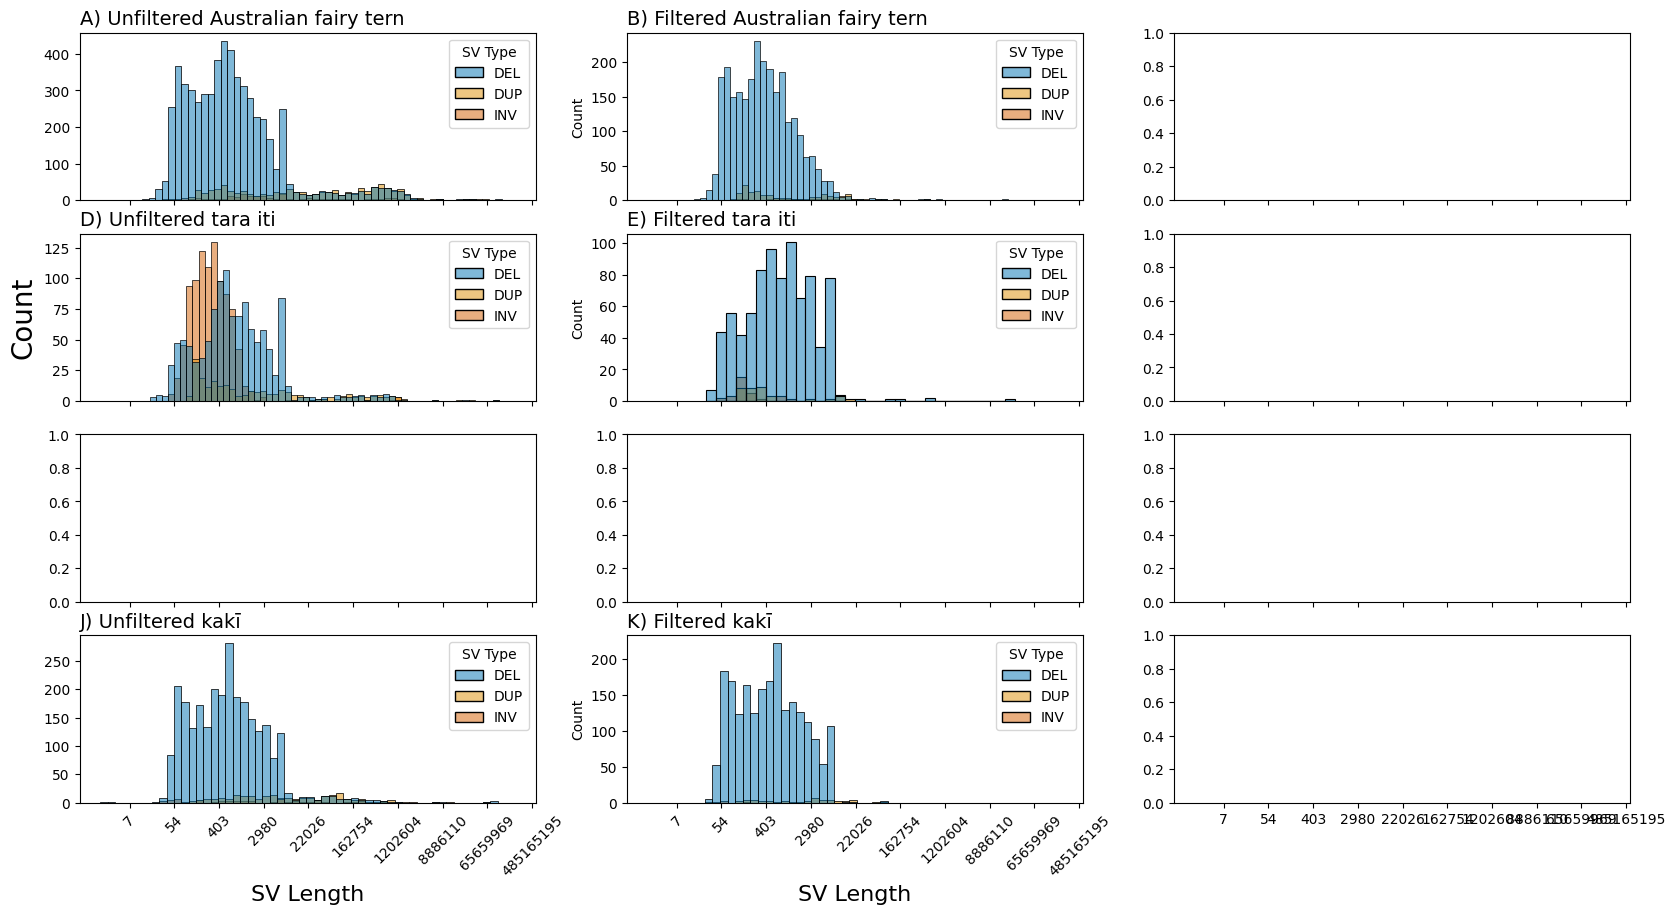

In [ ]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']
SVs['SV Length'] = pd.to_numeric(SVs['SV Length'], errors='coerce')
SVs['Log Length'] = np.log(SVs['SV Length'])

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

palette = {'DEL': '#0173b2', 'DUP': '#de8f05', 'INV': '#d55e00'}
order = ['DEL', 'DUP', 'INV']
populations = {'AU': auSVs, 'TI': tiSVs, 'KI_10x':kiLCSVs, 'KI': kiSVs}
titles = {'AU': 'Australian fairy tern', 'TI': 'tara iti', 'KI': 'kakī'}

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey=False)

x_ticks_log = np.arange(2, 22, 2)
x_labels = np.exp(x_ticks_log).astype(int)

sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0, 0])
axes[0, 0].set_title('A) Unfiltered Australian fairy tern', fontsize=14, loc='left')
axes[0, 0].set_xticks(x_ticks_log)
axes[0, 0].set_ylabel('')
#axes[0, 0].set_ylim(0, 950)
sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0, 1])
axes[0, 1].set_title('B) Filtered Australian fairy tern', fontsize=14, loc='left')
axes[0, 1].set_xticks(x_ticks_log)
#axes[0, 1].set_ylim(0, 300)

sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1, 0])
axes[1, 0].set_title('D) Unfiltered tara iti', fontsize=14, loc='left')
axes[1, 0].set_xticks(x_ticks_log)
axes[1, 0].set_ylabel('Count', fontsize=20)
#axes[1, 0].set_ylim(0, 950)
sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1, 1])
axes[1, 1].set_title('E) Filtered tara iti', fontsize=14, loc='left')
axes[1, 1].set_xticks(x_ticks_log)
#axes[1, 1].set_ylim(0, 300)

sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[3, 0])
axes[3, 0].set_title('J) Unfiltered kakī', fontsize=14, loc='left')
axes[3, 0].set_xticks(x_ticks_log)
axes[3, 0].set_ylabel('')
axes[3, 0].set_xticklabels(x_labels, rotation=45)
axes[3, 0].set_xlabel('SV Length', fontsize=16)
#axes[3, 0].set_ylim(0, 950)
sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[3, 1])
axes[3, 1].set_title('K) Filtered kakī', fontsize=14, loc='left')
axes[3, 1].set_xticks(x_ticks_log)
axes[3, 1].set_xticklabels(x_labels, rotation=45)
axes[3, 1].set_xlabel('SV Length', fontsize=16)
#axes[3, 1].set_ylim(0, 300)


#plt.savefig('plots/Supp_Fig_SV_log_length_distributions.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'SV Length')

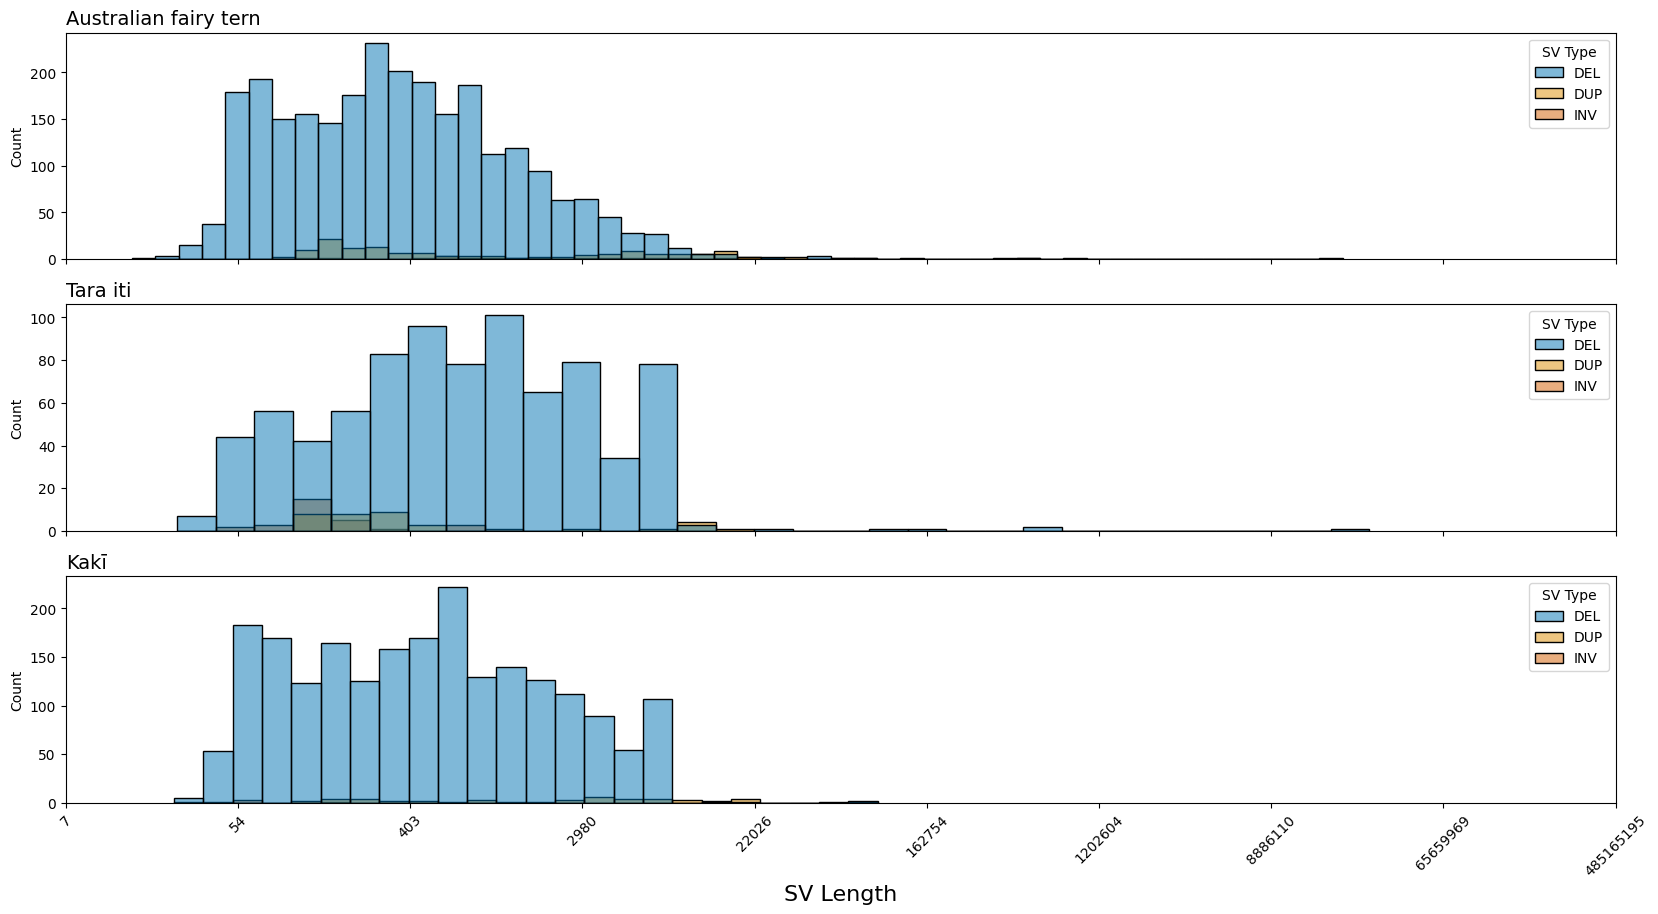

In [ ]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']
SVs['SV Length'] = pd.to_numeric(SVs['SV Length'], errors='coerce')
SVs['Log Length'] = np.log(SVs['SV Length'])

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

palette = {'DEL': '#0173b2', 'DUP': '#de8f05', 'INV': '#d55e00'}
order = ['DEL', 'DUP', 'INV']
populations = {'AU': auSVs, 'TI': tiSVs, 'KI_10x':kiLCSVs, 'KI': kiSVs}
titles = {'AU': 'Australian fairy tern', 'TI': 'tara iti', 'KI_10x': 'low coverage kakī', 'KI': 'kakī'}

fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=False)

x_ticks_log = np.arange(2, 22, 2)
x_labels = np.exp(x_ticks_log).astype(int)

sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0])
axes[0].set_title('Australian fairy tern', fontsize=14, loc='left')
axes[0].set_xticks(x_ticks_log)

sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1])
axes[1].set_title('Tara iti', fontsize=14, loc='left')
axes[1].set_xticks(x_ticks_log)

sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[2])
axes[2].set_title('Kakī', fontsize=14, loc='left')
axes[2].set_xticks(x_ticks_log)
axes[2].set_xticklabels(x_labels, rotation=45)
axes[2].set_xlabel('SV Length', fontsize=16)

#plt.savefig('plots/Supp_Fig_SV_log_length_distributions.png', dpi=300, bbox_inches='tight')

Filtering

```
bcftools view -i 'SVTYPE!="BND" & INFO/IMPRECISE!=1 & N_PASS(GT="mis")=0' 01_GLOBAL_genotypes.smoove.square.vcf.gz | \
    bcftools view -i '(SVTYPE = "DEL" & FMT/DHFFC[0-74] < 0.7) | (SVTYPE = "DUP" & FMT/DHBFC[0-74] > 1.3) | (SVTYPE = "INV")' -O b -o 02_GLOBAL_filtered.bcf
```

## SV Evaluation
Genotypes were visually inspected for support by plotting with SAMplot and scoring with [PlotCritic](https://github.com/jbelyeu/PlotCritic). As with Smeds et al. only one curator was used to prevent the overfiltering of genotypes. We used BCFtools to first extract regions of interest for each individual.
```
bcftools view -i 'SVTYPE=!"INS" & GT=="RR"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thomRef\n]' 02_fairy_genotypes_filtered.vcf.gz > fairy_samplot_regions.tsv
bcftools view -i 'SVTYPE=!"INS" & GT=="het"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thet\n]' 02_fairy_genotypes_filtered.vcf.gz >> fairy_samplot_regions.tsv
bcftools view -i 'SVTYPE=!"INS" & GT=="AA"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thomAlt\n]' 02_fairy_genotypes_filtered.vcf.gz >> fairy_samplot_regions.tsv

bcftools view -i 'SVTYPE=!"INS" & GT=="RR"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thomRef\n]' 02_kaki_genotypes_filtered.vcf.gz > kaki_samplot_regions.tsv
bcftools view -i 'SVTYPE=!"INS" & GT=="het"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thet\n]' 02_kaki_genotypes_filtered.vcf.gz >> kaki_samplot_regions.tsv
bcftools view -i 'SVTYPE=!"INS" & GT=="AA"' -f [%CHROM\t%POS\t%END\t%SVTYPE\t%SAMPLE\thomAlt\n]' 02_kaki_genotypes_filtered.vcf.gz >> kaki_samplot_regions.tsv
```

These regions were then plotted into individual folders with SAMPLOT.  
```
while read -r line
    do
    CHROM=$(echo $line | awk '{print $1})
    START=$(echo $line | awk '{print $2})
    ENDIN=$(echo $line | awk '{print $3})
    SVTYP=$(echo $line | awk '{print $4})
    SAMPL=$(echo $line | awk '{print $5})
    GENOS=$(echo $line | awk '{print $6})
    printf "STARTED SAMPLOT FOR $SAMPL ${CHROM}:${START} AT "
    date
    samplot plot -n ${SAMPL} -b alignments/${SAMPL}_nodup_autosomes.bam \
        -o fairy_SAMplot/${SVTYP}_${CHROM}_${START}_${ENDIN}_${SAMPLE}_${GENOS}.png \
        -c $CHROM \
        -s $START \
        -e $ENDIN \
        -t $SVTYP
done < fairy_samplot_regions.tsv
```
This was then repeated for kakī genotypes.  

We then created PlotCritic projects and manually scored all SV genotypes.  
```
plotcritic -p fairy_genos -i fairy_SAMplot/ -q "What is the Genotype? -A "a":"HomRef" "b":"Het" "c":"HomAlt"
plotcritic -p kaki_genos -i kaki_SAMplot/ -q "What is the Genotype? -A "a":"HomRef" "b":"Het" "c":"HomAlt"
```
Scored genotypes were then extracted from the PlotCritic Summary files upon completion of scoring.  
```
printf "Chromosome\tPosition\tEnd\tSV_type\tSample\tGraphTyper_GT\thomRef_score\thet_score\thomAlt_score\n" > {kaki,fairy}_scores.tsv
tail -n+4 fairy_genos/fairy_genos_summary_report.tsv | tr '_' '\t' | awk '{print $2"_"$3"\t"$4"\t"$5"\t"$1"\t"$6"\t"$7"\t"$8"\t"$9"\t"$10}' >> fairy_scores.tsv

printf "Chromosome\tPosition\tEnd\tSV_Type\tSample\tGraphTyper_GT\tPlotCritic_GT\n" > fairy_genos.tsv
tail -n+2 fairy_scores.tsv | awk '{if ($7==100) print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t0";
    else if ($8==100) print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t1";
    else if ($9==100) print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t2"}' >> fairy_genos.tsv

tail -n+4 kaki_genos/kaki_genos_summary_report.tsv | tr '_' '\t' | awk '{print $2"_"$3"\t"$4"\t"$5"\t"$1"\t$6"\t"$7"\t"$8"\t"$9"\t"$10}' >> kaki_scores.tsv
awk '{if ($7==100) print $1"\t"$3"\t"$3"\t"$4"\t"$5"\t"$6"\t0";
    else if ($8==100) print $1"\t"$3"\t"$3"\t"$4"\t"$5"\t"$6"\t1";
    else if ($9==100) print $1"\t"$3"\t"$3"\t"$4"\t"$5"\t"$6"\t2"}' kaki_scores.tsv >> kaki_genos.tsv
```
The number counts of each genotype for each individual were then acquired as below.  
```
tail -n+2 fairy_genos.tsv | cut -f5,7 | sort | uniq -c
```
## Population Structure and Differentiation
### MDS
We prepared the called SVs for ngsDist by using BCFtools to output the posterior probabilities (`FORMAT/PL`) for each individual's genotype.  
```
bcftools query -f '%CHROM\t%POS\t[%PL\t]\n' graphtyper/02_fairy_genotypes_filtered.vcf.gz | sed 's/,/\t/g' | gzip -c > graphtyper/fairy_mds/fairy_SVgenos.tsv.gz

NSITES=$(zcat graphtyper/fairy_mds/fairy_SVgenos.tsv.gz | wc -l)
ngsDist --geno graphtyper/fairy_mds/fairy_SVgenos.tsv.gz --probs --log_scale \
    -n_ind 34 -n_sites $NSITES -labels graphtyper/fairy_mds/mds_list -o graphtyper/fairy_mds/GLOBAL_svDist

tail -n +3 graphtyper/fairy_mds/GLOBAL_svDist | Rscript --vanilla --slave getMDS.R \
    --no_header --data_symm -n 4 -m "mds" -o graphtyper/fairy_mds/GLOBAL_sv.mds
```
### F<sub>ST</sub>
```
vcftools --gzvcf 02_fairy_genotypes.vcf.gz \
    --weir-fst-pop AU_samples.txt \
    --weir-fst-pop TI_samples.txt \
    --out fst/AU_TI
```

## Intersections with BUSCO genes
After calling BUSCO sites for the tara iti and kakī genome assemblies, we extracted regions corresponding with complete, single-copy BUSCOs and those regions corresponding to our autosomal chromosomes.
```
cut -f2,3,4,5 run_aves_odb10/full_table.tsv | grep Complete | awk '{print $2"\t"$3"\t"$4"\t"$5}' > SP01_scBUSCOs.bed

while read -r line
    do
    CHROM=(echo $line | awk '{print $1}')
    printf "EXTRACTING CHROMOSOME $CHROM...\n"
    grep "$CHROM" SP01_scBUSCOs.bed >> SP01_autosome_scBUSCOs.bed
done < SP01_autosomes2.bed

sort -k1,1 -k2,2n SP01_autosome_scBUSCOs.bed > SP01_autosome_scBUSCOs.sorted.bed
```
After extracting BUSCOs corresponding to our autosomal scaffolds, we identified SVs overlapping these genes by extracting SV regions and finding intersecting sites with BCFtools and BEDtools.  

```
bcftools query -f '%CHROM\t%POS\t%SVLEN\n' 02_fairy_genotypes_filtered.vcf.gz | awk '{print $1"\t"$2"\t"$2+$3}' | sort -k1,1 -k2,2n > fairy_sv.bed

bedtools intersect -wa -a fairy_sv.bed  -b SP01_autsome_scBUSCOs.sorted.bed | awk '{print $1"\t"$2}' > fairy_BUSCO_svs.txt

bcftools view -T fairy_BUSCO_svs.txt -O z -o 03_fairy_BUSCO.vcf.gz 02_fairy_genotypes_filtered.vcf.gz
```
## Site Frequency Spectrum
To generate a site frequency spectrum for SVs, we generated population specific VCFs for each group and attempted to polarise the VCFs with genotypes from reads used to polarise the SNP-base SFS. However, SVs were not reliably genotyped in either tern outgroup or the pied avocet for kakī. This made comparisons of allele counts intersecting BUSCO genes with SNP-based estimates of load challenging. However, given that the BUSCO regions were identified as single-copy and complete in our reference individuals, we assumed any SV intersecting with these regions would be under strong purifying selection and therefore is the 'derived' allele. To ensure comparisons between fairy terns was comparable, we excluded any SVs private to one group as below. For kakī, we repeated the process using the poaka.  

```
bcftools view -S TI_sampleIDs.txt 02_fairy_genotypes_filtered.vcf.gz | bcftools view -i 'GT=="alt"' -O z -o 03_TI_genotypes_filtered.vcf.gz
bcftools view -S AU_sampleIDs.txt 02_fairy_genotypes_filtered.vcf.gz | bcftools view -i 'GT=="alt"' -O z -o 03_AU_genotypes_filtered.vcf.gz

bcftools index 03_TI_genotypes_filtered.vcf.gz
bcftools index 03_AU_genotypes_filtered.vcf.gz

bcftools index 02_pied_genotypes_filtered.vcf.gz
bcftools index 02_kaki_genotypes_filtered.vcf.gz # high-coverage kakī genotypes
bcftools index 02_KI_10x_of_10x_SVs_filtered.vcf.gz # low-coverage _kakī genotypes

bcftools isec 03_TI_genotypes_filtered.vcf.gz 03_AU_gentoypes_filtered.vcf.gz -p fairy_intersection/
bcftools isec 02_kaki_genotypes_filtered.vcf.gz 02_pied_genotypes_filtered.vcf.gz -p stilt_intersection/
bcftools isec 02_KI_10x_of_10x_SVs_filtered.vcf.gz 02_pied_genotypes_filtered.vcf.gz -p stilt10x_intersection/
```
Finally, we created our individuals and population frequency files.  
```
bcftools query -T fairy_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tTI\tIntersecting\n]' fairy_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv
bcftools query -T ^fairy_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tTI\tNonintersecting\n]' fairy_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv

bcftools query -T fairy_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tAU\tIntersecting\n]' fairy_intersection/0003.vcf >> indiv_harmful_SVallele_frequency.tsv
bcftools query -T ^fairy_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tAU\tNonintersecting\n]' fairy_intersection/0003.vcf >> indiv_harmful_SVallele_frequency.tsv

bcftools query -T kaki_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tKI\tIntersecting\n]' stilt_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv
bcftools query -T ^kaki_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tKI\tNonintersecting\n]' stilt_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv

bcftools query -T kaki_10x_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tKI\tIntersecting\n]' stilt10x_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv
bcftools query -T ^kaki_10x_BUSCO_svs.txt -f '[%CHROM\t%POS\t%SVTYPE\t%SVLEN\t%SAMPLE\t%GT\tKI\tNonintersecting\n]' stilt10x_intersection/0002.vcf >> indiv_harmful_SVallele_frequency.tsv
```
## SV Profiling with Repeat Annotation
1) Extract SV START/END positions into bed and extract sequence information into fasta file by SVTYPE.  
```
count=1
bcftools query -f '%CHROM\t%POS\t%END\t%SVTYPE\n' 03_fairy_filteredSVs.vcf.gz | while read line
        do
        echo $line | awk -v var="$count" '{print $1"\t"$2-30"\t"$2+30"\t"$3-30"\t"$3+30"\t"$4"\t"var}' >> fairy_SV_intervals.txt
        ((count++))
done
```
We then divided these intervals into 'start' and 'end', and included variant and count information to identify specific variants associated with each interval.  
```
awk '{print $1"\t"$2"\t"$3"\t"$6"_"$7"_start"}' fairy_SV_intervals.txt > fairy_intervals.bed
awk '{print $1"\t"$4"\t"$5"\t"$6"_"$7"_end"}' fairy_SV_intervals.txt >> fairy_intervals.bed

bedtools getfasta -fi Katie_5kb_ragtag.fa -bed fairy_intervals.bed -fo fairy_intervals.fasta
```
Now we adjust the names of the relevant fasta files to relate to their specific SV IDs.  
```
awk '{print $1":"$2"-"$3"\t"$1":"$2"-"$3":"$4}' fairy_intervals.bed > fairy_rename.txt

seqkit replace --pattern '(.+)' --replacement '{kv}' --kv-file fairy_rename.txt fairy_intervals.fasta --keep-key > fairy_intervals_renamed.fasta
```
2) Get repeat sequences for query by converting GFF3 to BED from complex regions predicted by repeatmodeler
```
awk '{print $1"\t"$4"\t"$5"\t"$9}' tara-iti-repeat-masked/Katie_5kg_ragtag-renamed.complex_mask.gff3 | sed 's/Target=//g' > Katie_complex.bed
```
3) Rename chromosome names and create a file containing repeat motif ID
```
grep ">" tara-iti-repeat-masked/Katie_5kg_ragtag-renamed.simple_mask.soft.complex_mask_hard.fasta | sed 's/>//g' > seqkit.txt
grep ">" reference/Katie_5kb_ragtag.fasta | sed 's/>//g' > fasta.txt
paste seqkit.txt fasta.txt > fairy_chrom_name_conversion.tsv

awk '{print $1"_"$4"-"$5"#"$9}' tara-iti-repeat-masked/Katie_5kb_ragtag-renamed.complex_mask.gff3 | sed 's/Target=//g' | sed 's%/%%g' > fairy_gff_ids.txt

while read -r line
    do
    SEQID=$(echo $line | awk '{print $1}')
    CHROM=$(echo $line | awk '{print $2}')
    echo "CONVERTING $SEQID TO $CHROM..."
    sed -i "s/$SEQID/$CHROM/g" fairy_gff_ids.txt
    sed -i "s/$SEQID/$CHROM/g" Katie_complex.bed
done < fairy_chrom_name_conversion.tsv
```
To make sure the correct repeat IDs were aligned to the correct locations we checked as per:
```
awk '{FS="#"} {print $1} fairy_chrom_name_conversion.tsv | sed 's/RagTag_/RagTag:/g' | awk '{if ($1!=$2) print $0}'
```
Although there were overlaps that caused chomosome names to have numbers overlapping, we found that the bp coordinates matched between the two.  
4) Get fasta sequence interval for these repeats
```
bedtools getfasta -fi Katie_5kb_ragtag.fa -bed Katie_complex.bed -fo Katie_complex.fasta
```
5) Convert names in fasta file to contain repeat motifs
```
seqkit replace --pattern '(.+)' \
    --replacement '{kv}' \
    --kv-file fairy_rename_ids.txt Katie_complex.fasta \
    --keep-key > Katie_complex_repeat_names.fasta
```
Repeat masker has a maximum character limit of 50 for sequence names. `_RagTag` was excluded from the fasta file to run RepeatMasker.  
```
sed -i 's/_RagTag//g' Katie_complex_repeat_names.fasta
```
6) Query repeat sequences using SV breakend sequences with RepeatMasker
```
RepeatMasker -pa 8 -lib Katie_complex_repeat_names.fasta -dir ./ fairy_intervals_renamed.fasta
```
7) Extract hit locations and their repeat types for plotting.  

```
printf "Chromosome\tStart\tEnd\tSV Type\tVariant ID\tVariant Position\tRepeat\n" > fairy_repeat_hits.tsv

tail -n+4 fairy_intervals_renamed.fasta.out | \
    sed 's/[[:blank:]]\+/\t/g' | \
    cut -f 6,12 | \
    sed 's/Low_complexity/LowComplexity/g' | \
    sed 's/Simple_repeat/SimpleRepeat/g' | \
    sed 's/DNA?/DNA/g' | \
    sed -e 's/:\|-\|_/\t/g' | \
    sort -k1,1 -k2,2n | \
    awk '{FS="\t"} { if (NF>7) print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$7; else print $0}' | \
    uniq >> fairy_repeat_hits.tsv
```
Now we need to identify which variants did not align to repeat elements. For this, we leverage the full `fairy_SV_intervals.tsv` file and the assigned variant IDs from step 1. We first extract the variant ID and positions representing SVs with positive hits into a new file.  
```
tail -n+2 fairy_repeat_hits.tsv | awk '{print $4"_"$5"_"$6}' > fairy_positive_hits.tsv
```
Now we extract those SVs that did not have hits.  
```
grep -v -f fairy_positive_hits.tsv fairy_intervals.bed | sed 's/_RagTag//g' | sed 's/_/\t/g' | awk '{print $0"\tNoRepeat"}'
```
After genotyping (as outlined below), we identified the relationship between SVs that were genotyped and the repeat landscape in the fairy tern and kakī genomes by extracting the start and ending positions from the relevant VCFs and `*_repeat_hits.tsv` files.  
```
bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 03_AU_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$2-30"\t"$2+30"\t"$4}' | \
    sed 's/_RagTag//g' > AU_genos_start.tsv
bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 03_AU_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$3-30"\t"$3+30"\t"$4}' | \
    sed 's/_RagTag//g' > AU_genos_end.tsv

bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 03_TI_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$2-30"\t"$2+30"\t"$4}' | \
    sed 's/_RagTag//g' > TI_genos_start.tsv
bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 03_TI_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$3-30"\t"$3+30"\t"$4}' | \
    sed 's/_RagTag//g' > TI_genos_end.tsv

bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 02_KI_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$2-30"\t"$2+30"\t"$4}' > KI_genos_start.tsv
bcftools query -f '%CHROM\tPOS\t%END\t%SVTYPE\n' 02_KI_genotypes_filtered.vcf.gz | \
    awk '{print $1"\t"$3-30"\t"$3+30"\t"$4}' > KI_genos_end.tsv
```
Now extracting the relevant repeat motifs.
```
grep -f AU_genos_start.tsv fairy_repeat_hits.tsv | grep -v end > fairy_geno_repeats.tsv
grep -f AU_genos_end.tsv fairy_repeat_hits.tsv | grep end >> fairy_geno_repeats.tsv
grep -f TI_genos_start.tsv fairy_repeat_hits.tsv | grep -v end >> fairy_geno_repeats.tsv
grep -f TI_genos_end.tsv fairy_repeat_hits.tsv | grep end >> fairy_geno_repeats.tsv

grep -f KI_genos_start.tsv kaki_repeat_hits.tsv | grep -v end > kaki_geno_repeats.tsv
grep -f KI_genos_start.tsv kaki_repeat_hits.tsv | grep end >> kaki_geno_repeats.tsv
```


### Association with Repeats
Here we leverage an approach implemented by Katarina Stewart in a manuscript under review with Molecular Ecology to identify SVs overlapping with repeats annotated in the tara iti and kakī genome assemblies. Please see [03_SV_discovery_and_PopGen.md](https://github.com/janawold1/2024_MolEcol_ConsGen_Special_Issue/blob/main/03_SV_discovery_and_PopGen.md) for how intersections between SVs and these repeats were identified.  

First we load the data frames and identify which SVs had repeats and which did not. Those that were not were then included in the analyses below. 
```
fairy_repeats = pd.read_csv('repeatmasker/tara_iti_all_repeat_summary_autosomes_simple.tsv', sep='\t')
fairy_repeats.drop_duplicates(subset=['Chromosome', 'Repeat'], inplace=True)
fairy_repeat_svs = pd.read_csv('repeatmasker/fairy_repeat_hits.tsv', sep='\t')

fairy_repeat_svs.drop_duplicates(subset=['Chromosome', 'Start', 'End', 'SV Type', 'Variant ID', 'Repeat'], inplace=True)
fairy_repeat_svs = fairy_repeat_svs[fairy_repeat_svs['Repeat']!='NoRepeat']
fairy_SVrepeat_counts = fairy_repeat_svs.groupby(['Chromosome', 'SV Type', 'Repeat']).size().reset_index(name='Count')

kaki_repeats = pd.read_csv('repeatmasker/kaki_all_repeat_summary_autosomes_simple.tsv', sep='\t')

kaki_repeat_svs = pd.read_csv('repeatmasker/kaki_repeat_hits_simple.tsv', sep='\t')
kaki_repeat_svs.drop_duplicates(subset=['Chromosome', 'Start', 'End', 'SV Type', 'Variant ID', 'Repeat'], inplace=True)

# Specify the order of kakī chromosomes
chromosome_order = ['scaffold_1', 'scaffold_2', 'scaffold_3', 'scaffold_5', 'scaffold_6', 'scaffold_7', 'scaffold_8', 'scaffold_9',
                    'scaffold_10', 'scaffold_11', 'scaffold_12', 'scaffold_13', 'scaffold_14', 'scaffold_15', 'scaffold_16', 'scaffold_17',
                    'scaffold_18', 'scaffold_19', 'scaffold_20', 'scaffold_21', 'scaffold_22', 'scaffold_23', 'scaffold_24', 'scaffold_25',
                    'scaffold_26', 'scaffold_27', 'scaffold_28']  # Custom order
kaki_repeats['Chromosome'] = pd.Categorical(kaki_repeats['Chromosome'], categories=chromosome_order, ordered=True)
kaki_repeat_svs['Chromosome'] = pd.Categorical(kaki_repeat_svs['Chromosome'], categories=chromosome_order, ordered=True)
kaki_SVrepeat_counts = kaki_repeat_svs.groupby(['Chromosome', 'SV Type', 'Repeat']).size().reset_index(name='Count')

pivot_kaki_repeats = kaki_repeats.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
pivot_fairy_repeats = fairy_repeats.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
```

```
pivot_kaki_repeats.head()
```

Here we count all repeat classes for each group and plot the type of repeat discovered on each assembled chromosome in the tara iti and kakī genome assemblies.  

```
repeat_color_map = {
    'DNA': '#E69F00', 
    'LINE': '#56B4E9', 
    'LTR': '#009E73', 
    'Low Complexity': '#F0E442', 
    'Rolling Circle': '#0072B2', 
    'SINE': '#D55E00', 
    'Satellite': '#CC79A7', 
    'Simple Repeat': '#000000', 
    'Unknown': '#999999', 
    'tRNA': '#44AA99'
    }

figs, axes = plt.subplots(1, 2, figsize=(20,5), sharex=False, sharey=False)

pivot_fairy_repeats.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in pivot_kaki_repeats.columns], ax=axes[0], legend=False)
axes[0].set_title('A)', fontsize=20, loc='left')
axes[0].set_xlabel('Chromosome', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].set_xticks([])
axes[0].tick_params(axis='y', labelsize=16)

pivot_kaki_repeats.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in pivot_kaki_repeats.columns], ax=axes[1])
axes[1].set_title('B)', fontsize=20, loc='left')
axes[1].set_xlabel('Chromosome', fontsize=18)
axes[1].set_xticks([])
axes[1].tick_params(axis='y', labelsize=16)

plt.savefig('plots/Figure_rep_content_partA.png', dpi=300, bbox_inches='tight')
```
And here we examine the number of repeats intersecting SVs filtered for variant quality. We specifically examine deletions (C & F), duplications (D & G) and inversions (E & H).  
```
fairy_del_counts = fairy_SVrepeat_counts[fairy_SVrepeat_counts['SV Type']=='DEL']
fairy_del_pivot = fairy_del_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
fairy_dup_counts = fairy_SVrepeat_counts[fairy_SVrepeat_counts['SV Type']=='DUP']
fairy_dup_pivot = fairy_dup_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
fairy_ins_counts = fairy_SVrepeat_counts[fairy_SVrepeat_counts['SV Type']=='INS']
fairy_ins_pivot = fairy_ins_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
fairy_inv_counts = fairy_SVrepeat_counts[fairy_SVrepeat_counts['SV Type']=='INV']
fairy_inv_pivot = fairy_inv_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)

kaki_del_counts = kaki_SVrepeat_counts[kaki_SVrepeat_counts['SV Type']=='DEL']
kaki_del_pivot = kaki_del_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
kaki_dup_counts = kaki_SVrepeat_counts[kaki_SVrepeat_counts['SV Type']=='DUP']
kaki_dup_pivot = kaki_dup_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
kaki_ins_counts = kaki_SVrepeat_counts[kaki_SVrepeat_counts['SV Type']=='INS']
kaki_ins_pivot = kaki_ins_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)
kaki_inv_counts = kaki_SVrepeat_counts[kaki_SVrepeat_counts['SV Type']=='INV']
kaki_inv_pivot = kaki_inv_counts.pivot(index='Chromosome', columns='Repeat', values='Count').fillna(0)

figs, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False, sharey=False)

fairy_del_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in fairy_del_pivot.columns], ax=axes[0,0], legend=False)
axes[0,0].set_title('C)', fontsize=20, loc='left')
axes[0,0].set_xticks([])
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Count', fontsize=18)
axes[0,0].tick_params(axis='y', labelsize=16)

fairy_dup_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in fairy_dup_pivot.columns], ax=axes[0,1], legend=False)
axes[0,1].set_title('D)', fontsize=20, loc='left')
axes[0,1].set_xticks([])
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='y', labelsize=16)

fairy_ins_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in fairy_ins_pivot.columns], ax=axes[0,2], legend=False)
axes[0,2].set_title('E)', fontsize=20, loc='left')
axes[0,2].set_xticks([])
axes[0,2].set_xlabel('')
axes[0,2].tick_params(axis='y', labelsize=16)

fairy_inv_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in fairy_inv_pivot.columns], ax=axes[0,3], legend=False)
axes[0,3].set_title('F)', fontsize=20, loc='left')
axes[0,3].set_xticks([])
axes[0,3].set_xlabel('')
axes[0,3].tick_params(axis='y', labelsize=16)

kaki_del_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in kaki_del_pivot.columns], ax=axes[1,0], legend=False)
axes[1,0].set_title('G)', fontsize=20, loc='left')
axes[1,0].set_xticks([])
axes[1,0].set_ylabel('Count', fontsize=18)
axes[1,0].set_xlabel('Chromosome', fontsize=18)
axes[1,0].tick_params(axis='y', labelsize=16)

kaki_dup_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in kaki_dup_pivot.columns], ax=axes[1,1], legend=False)
axes[1,1].set_title('H)', fontsize=20, loc='left')
axes[1,1].set_xticks([])
axes[1,1].set_xlabel('Chromosome', fontsize=18)
axes[1,1].tick_params(axis='y', labelsize=16)

kaki_ins_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in kaki_ins_pivot.columns], ax=axes[1,2], legend=False)
axes[1,2].set_title('I)', fontsize=20, loc='left')
axes[1,2].set_xticks([])
axes[1,2].set_xlabel('Chromosome', fontsize=18)
axes[1,2].tick_params(axis='y', labelsize=16)

kaki_inv_pivot.plot(kind='bar', stacked=True, color=[repeat_color_map[repeat] for repeat in kaki_inv_pivot.columns], ax=axes[1,3], legend=False)
axes[1,3].set_title('J)', fontsize=20, loc='left')
axes[1,3].set_xticks([])
axes[1,3].set_xlabel('Chromosome', fontsize=18)
axes[1,3].tick_params(axis='y', labelsize=16)

plt.savefig('plots/Figure_rep_content_partB.png', dpi=300, bbox_inches='tight')

```